Initialisation 

In [1]:
# pip install networkx
# pip install pyproj

import pandas as pd
import csv
import math
import networkx as nx 
import heapq

# numpy pour dijkstra 
import numpy as np
from numpy import Inf

#Widget
import ipywidgets as widgets
from IPython.display import display

#Map interactive
import folium as f
from folium.plugins import MarkerCluster

#Map pour connection
import matplotlib.pyplot as plt
%matplotlib inline

#Calcul great circle
import pyproj


#import os
#import flightradar24

## Regles de codage 


In [2]:
'''
type_nom_variable
nomFonction(nom_variable : type) 
\'''
    description
    retour :  avec un exemple de forme 
\'''

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

'''

"\ntype_nom_variable\nnomFonction(nom_variable : type) \n'''\n    description\n    retour :  avec un exemple de forme \n'''\n\naeroport ipv airports \nvol --> routesANLO --> df_vols\nroutes --> dict_routes \n\n"

## Importation des données

In [3]:
chemin="../data/"

#df_aeroports = pd.read_csv(chemin + "aeroportsANLO.csv")
#df_zones = pd.read_csv(chemin + "zonesANLO.csv")
df_vols = pd.read_csv(chemin + "routesANLO.csv")
#df_compagnies = pd.read_csv(chemin + "compagniesANLO.csv")

In [4]:
dict_compagnies = {}

with open(chemin+'compagniesANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    next(reader, None)
    headers = ['Name','Country']
    dict_compagnies = {rows[2]:dict(zip(headers,[rows[0],rows[3]])) for rows in reader}


In [5]:
dict_aeroports = {}

with open(chemin+'aeroportsANLO.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_aeroports = {rows[1]:dict(zip(headers,rows[0:8])) for rows in reader}

dict_aeroports['CDG']

{'Name': 'Paris Charles de Gaulle Airport',
 'Iata': 'CDG',
 'Icao': 'LFPG',
 'Lat': '49.012516',
 'Lon': '2.555752',
 'Country': 'France',
 'Alt': '392',
 'City': 'Paris'}

In [6]:
dict_pays = {}

with open(chemin+'countries.csv', mode='r') as inp:
    reader = csv.reader(inp)
    headers = next(reader, None)
    dict_pays = {rows[1]:rows[0] for rows in reader}

dict_pays

{'Algeria': 'Africa',
 'Angola': 'Africa',
 'Benin': 'Africa',
 'Botswana': 'Africa',
 'Burkina Faso': 'Africa',
 'Burundi': 'Africa',
 'Cameroon': 'Africa',
 'Cape Verde': 'Africa',
 'Central African Republic': 'Africa',
 'Chad': 'Africa',
 'Comoros': 'Africa',
 'Congo': 'Africa',
 'Democratic Republic Of The Congo': 'Africa',
 'Djibouti': 'Africa',
 'Egypt': 'Africa',
 'Equatorial Guinea': 'Africa',
 'Eritrea': 'Africa',
 'Ethiopia': 'Africa',
 'Gabon': 'Africa',
 'Gambia': 'Africa',
 'Ghana': 'Africa',
 'Guinea': 'Africa',
 'Guinea-Bissau': 'Africa',
 "Cote D'ivoire (Ivory Coast)": 'Africa',
 'Kenya': 'Africa',
 'Lesotho': 'Africa',
 'Liberia': 'Africa',
 'Libya': 'Africa',
 'Madagascar': 'Africa',
 'Malawi': 'Africa',
 'Mali': 'Africa',
 'Mauritania': 'Africa',
 'Mauritius': 'Africa',
 'Morocco': 'Africa',
 'Mozambique': 'Africa',
 'Namibia': 'Africa',
 'Niger': 'Africa',
 'Nigeria': 'Africa',
 'Rwanda': 'Africa',
 'Sao Tome And Principe': 'Africa',
 'Senegal': 'Africa',
 'Seychell

In [7]:
df_vols = df_vols[["Depart","Arrivee","Code_ICAO"]].dropna()

In [8]:
#Nettoyage de la df_vols
for _, ligne in df_vols.iterrows():
    if not(ligne.Depart in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Depart'] == ligne.Depart].index, inplace=True)
    
    if not(ligne.Arrivee in dict_aeroports):
        df_vols.drop(df_vols[df_vols['Arrivee'] == ligne.Arrivee].index, inplace=True)

In [9]:
def coordDepuisAeroport(iata : str):
    '''
    Fonction : Recherche les coordonnées GPS d'un aéroport
    Retour : lat : float ,lon : float --> Latitude & longitude de l'aéroport
    '''
    lat = float(dict_aeroports[iata]['Lat'])
    lon = float(dict_aeroports[iata]['Lon'])
    return lat,lon

def DistGrandCercle(lat1 : float, lon1 : float, lat2 : float, lon2 : float):
    #Conversion en radian
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    #Delta des coordonnées
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #Rayon terrestre (en km)
    r = 6367.0

    #Formule d'Haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * r * math.asin(math.sqrt(a))


def DistGrandCercleICAO(icao1 : str, icao2 : str):
    #Récupération des coordonnées des aéroports
    latDep, lonDep = coordDepuisAeroport(icao1)
    latArr, lonArr = coordDepuisAeroport(icao2)

    #On calcule la distance les séparant,                                                     
    return DistGrandCercle(latDep,lonDep,latArr,lonArr)

In [10]:
dict_route = {}

g = df_vols.groupby(['Depart','Arrivee'])
taille_groupe = g.size().items()

for liaison, nbrVols in taille_groupe:
    #Si la liaison est déjà dans le dict, on incrémente le nbr de vols
    if(frozenset(liaison) in dict_route):
        dict_route[frozenset(liaison)]['Vols'] += nbrVols
    #Sinon, on crée une nouvelle liaison
    else:
        dict_route[frozenset(liaison)] = {'Dist' : DistGrandCercleICAO(liaison[0],liaison[1]), 'Vols' : nbrVols}

#Exemple :
dict_route[frozenset(('CDG','SIN'))]

{'Dist': 10717.48589664754, 'Vols': 5}

In [11]:
def filtreDictAeroports(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des aéroports
    '''
    Listtmp = []
    for (key, value) in dict_aeroports.items():
        if value[colonne] == valeur:
            Listtmp.append(key)
        
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

def filtreDictCompagnies(colonne : str, valeur : str):
    '''
    Fonction : Filtre les clés du dictionnaire en fonction d'une valeur 
    présente dans les valeurs associées.
    Return : Liste de code ICAO des compagnies
    '''
    Listtmp = []
    for (key, value) in dict_compagnies .items():
        if value[colonne] == valeur:
            Listtmp.append(key)
            
        if valeur == '':
            Listtmp.append(value[colonne])
    return Listtmp

# Fonctions -- Correspondance 

In [12]:
def correspondanceAirport(code1 : str, code2 : str):
    '''
    fonction qui filtre le df_vols pour obtenir les correspondances
    retour : list des airports codes 
    '''
    r1 = df_vols[df_vols['Depart'] == code1]['Arrivee'].to_list()
    r2 = df_vols[df_vols['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

In [13]:
def creationEdges(graphe : nx.Graph, list_reference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    list_connections = correspondanceAirport(code1, code2)
    # pour gerer les correspondances 
    if list_reference.count(code1) == 0: list_reference.append(code1); 
    if list_reference.count(code2) == 0: list_reference.append(code2)
    
    for i in list_connections :
        if list_reference.count(i) == 0 : 
            list_reference.append(i)     
    
    index1 = list_reference.index(code1) 
    index2 = list_reference.index(code2)
   
    list_edges = list(map(lambda x : (index1, list_reference.index(x), int(DistGrandCercleICAO(code1, x))), list_connections))
    list_edges.extend(list(map(lambda y : (list_reference.index(y), index2, int(DistGrandCercleICAO(y, code2))), list_connections)))
    
    graphe.add_weighted_edges_from(list_edges)
    return list_edges

In [14]:
def dessinerGraphe(graphe, weighted : bool = False):
    fig = plt.figure(); 
    fig.set_size_inches(9, 9)
    fig.patch.set_facecolor('white')
 
    pos = nx.fruchterman_reingold_layout(graphe)
    nx.draw_networkx_nodes(graphe, pos, node_size = 200)
    nx.draw_networkx_edges(graphe,pos, edgelist= graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(graphe, pos)
    plt.autoscale()
    #plt.title((code1,code2))
    if(weighted): nx.draw_networkx_edge_labels(graphe, pos) # afficher le weight 

    plt.show()

In [15]:
def dijkstra(graphe : nx.Graph, start : int, end : int, list_reference: list):
    '''
        fonction qui utilise l'algorithme de Dijkstra pour calcule le plus court
        chemin et calcule le distance
        retour \: dict{\'distance\' : ... , \'path\' : ...}
    '''
    tmp1 = nx.dijkstra_path(graphe, start,end)
    dist = nx.dijkstra_path_length(graphe, start, end)
    tmp2 = []
    for i in range(0, len(tmp1)):
        tmp2.append(list_reference[tmp1[i]])
        
    return {'distance' : dist, 'path' : tmp2}

In [16]:
def nombreDeCorrespondances(g : nx.Graph, codeStart, codeFin):
    listRefInit = []
    listRefTotale = []
    listRetour = []
    listRetour.extend(creationEdges(g, listRefInit, codeStart, codeFin))
    for i in range(len(listRefInit)):
        listRetour.extend(creationEdges(g, listRefTotale, codeStart, listRefInit[i]))
        listRetour.extend(creationEdges(g, listRefTotale, listRefInit[i], codeFin))
    
    return listRefTotale
    


DUS AAL
{'distance': 801, 'path': ['DUS', 'AMS', 'AAL']}


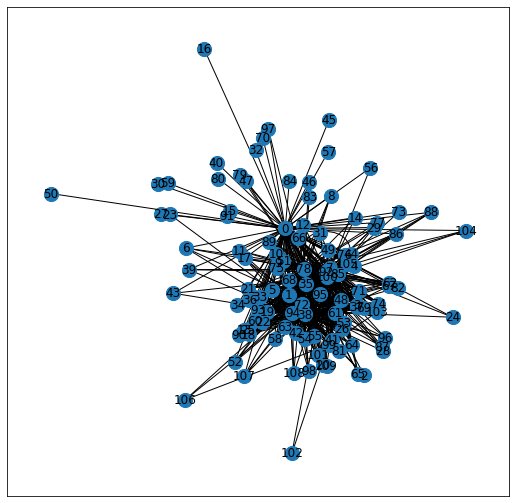

In [17]:
def traitementComplet(aeroport_start : str, aeroport_fin : str):
    
    aeroport_codeS = filtreDictAeroports('Name', aeroport_start)[0]
    aeroport_codeE = filtreDictAeroports('Name', aeroport_fin)[0] 
    print(aeroport_codeS, aeroport_codeE)
    g = nx.Graph(); 
    
    list_ref = nombreDeCorrespondances(g, aeroport_codeS, aeroport_codeE)
    resultat = dijkstra(g, list_ref.index(aeroport_codeS), list_ref.index(aeroport_codeE), list_ref)
    print(resultat)
    dessinerGraphe(g)
    
s1 = dict_aeroports['DUS']['Name']
s2 = dict_aeroports['AAL']['Name']
traitementComplet(s1, s2)

Widget StoryLine 

In [18]:
airportArrive = widgets.Dropdown(
    options= filtreDictAeroports('Name', ''),
    description='Airport Depart:',
    disabled=False,
)

airportDepart = widgets.Dropdown(
    options= filtreDictAeroports('Name', ''),
    description='Airport Depart:',
    disabled=False,
)

recommandationSelon = widgets.RadioButtons(
    options = {'distance', 'CO2', 'nombre de correspondances'}, 
    description = 'Recommendation selon : ',
    disable = False, 
)

In [19]:
airportArrive

Dropdown(description='Airport Depart:', options=('A Coruna Airport', 'Aachen Merzbruck Airport', 'Aalborg Airp…

In [20]:
airportDepart

Dropdown(description='Airport Depart:', options=('A Coruna Airport', 'Aachen Merzbruck Airport', 'Aalborg Airp…

In [21]:
recommandationSelon

RadioButtons(description='Recommendation selon : ', options=('distance', 'CO2', 'nombre de correspondances'), …

A Coruna Airport
LCG LCG
{'distance': 0, 'path': ['LCG']}


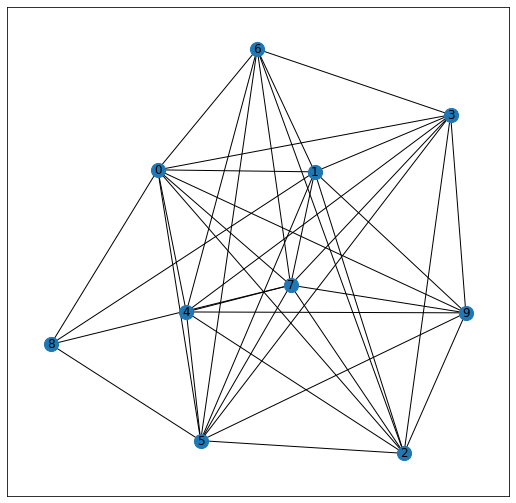

In [22]:
print(airportArrive.value)
traitementComplet(airportArrive.value, airportDepart.value)


# test dijkstra 

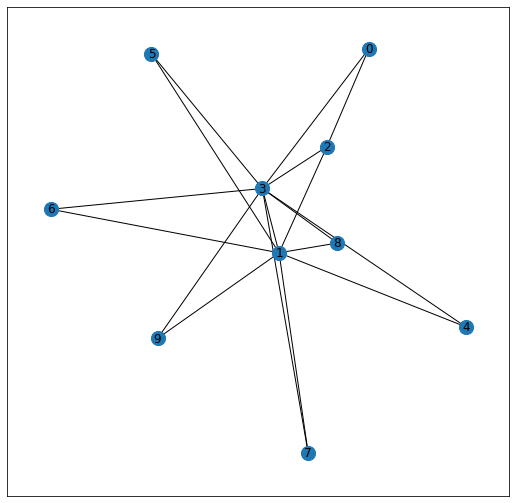

[[0, 2, 1, 3, 7], [0, 2, 1, 4, 3, 7], [0, 2, 1, 5, 3, 7], [0, 2, 1, 6, 3, 7], [0, 2, 1, 7], [0, 2, 1, 8, 3, 7], [0, 2, 1, 9, 3, 7], [0, 2, 3, 1, 7], [0, 2, 3, 4, 1, 7], [0, 2, 3, 5, 1, 7], [0, 2, 3, 6, 1, 7], [0, 2, 3, 7], [0, 2, 3, 8, 1, 7], [0, 2, 3, 9, 1, 7], [0, 3, 1, 7], [0, 3, 4, 1, 7], [0, 3, 5, 1, 7], [0, 3, 6, 1, 7], [0, 3, 7], [0, 3, 2, 1, 7], [0, 3, 8, 1, 7], [0, 3, 9, 1, 7]]


['AAL', 'DUS', 'FRA']

In [23]:
graphe_test = nx.Graph()
returnlist = []

conlist = creationEdges(graphe_test, returnlist, 'AAL', 'LNZ')
conlist.extend(creationEdges(graphe_test, returnlist, returnlist[1], returnlist[3] ))

dessinerGraphe(graphe_test)

#resultat = nx.all_shortest_paths(graphe_test, 0,7)

r2 = nx.all_simple_paths(graphe_test,source=0,target=7) # peut donner plus des correspondances 
print(list(r2))
resultat = dijkstra(graphe_test, 0, 7, returnlist) # meilleur cas 
#resultat['distance']
resultat['path']

In [24]:
def routeSelonNombreCorrespondances(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui trouve tous les chemins de start aux fin avec 'nombre' correspondances
        retour : dictionnaire en forme de {'nbRoute' : .. , 'path' : [ path1, path2 ]}
    '''
    r2 = list(nx.all_simple_paths(graphe_test,source=start,target=end))    
    r3 = list(filter(lambda x : len(x) == nombre, r2))
    
    return {"nbRoute" : len(r3), "path": r3}

def routeSelonNombreCorrespondanceLessThen(graphe : nx.Graph, nombre : int, start, end):
    '''
        fonction qui retourne tous les routes/correspondances avec un nombre de correspondances <= nombre 
        retour : un dictionnaire { nombre : {'nbRoute' : .. , 'path' : [ path1, path2 ]}, nombre2 : {..}}
    '''
    retour = dict(); 
    for i in range(nombre):
        tmp = routeSelonNombreCorrespondances(graphe, i , start, end)
        if(tmp['nbRoute'] > 0): retour[i] = tmp
    
    return retour

routeSelonNombreCorrespondanceLessThen(graphe_test, 10, 0,7)

{3: {'nbRoute': 1, 'path': [[0, 3, 7]]},
 4: {'nbRoute': 3, 'path': [[0, 2, 1, 7], [0, 2, 3, 7], [0, 3, 1, 7]]},
 5: {'nbRoute': 8,
  'path': [[0, 2, 1, 3, 7],
   [0, 2, 3, 1, 7],
   [0, 3, 4, 1, 7],
   [0, 3, 5, 1, 7],
   [0, 3, 6, 1, 7],
   [0, 3, 2, 1, 7],
   [0, 3, 8, 1, 7],
   [0, 3, 9, 1, 7]]},
 6: {'nbRoute': 10,
  'path': [[0, 2, 1, 4, 3, 7],
   [0, 2, 1, 5, 3, 7],
   [0, 2, 1, 6, 3, 7],
   [0, 2, 1, 8, 3, 7],
   [0, 2, 1, 9, 3, 7],
   [0, 2, 3, 4, 1, 7],
   [0, 2, 3, 5, 1, 7],
   [0, 2, 3, 6, 1, 7],
   [0, 2, 3, 8, 1, 7],
   [0, 2, 3, 9, 1, 7]]}}

In [25]:
def routeSelonDistance(graphe : nx.Graph, debut, fin):
    print(nx.dijkstra_path(graphe, debut, fin))

routeSelonDistance(graphe_test, 0,7)

[0, 3, 7]
